# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

https://www.kaggle.com/aakashns/pytorch-basics-linear-regression-from-scratch

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации  𝛼 , используя полные данные для обучения и для тестирования.

In [183]:
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import torch

In [184]:
D = np.loadtxt(r'C:\Users\user\Desktop\pm\Mishenin\1\classification-2020\data\lin_reg.txt', delimiter=',')
X = np.array(D[:, :-1], dtype='float32')
Y = np.array([D[:, -1]], dtype='float32')

In [185]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0) 
Y = (Y - np.mean(Y, axis=1)) / np.std(Y, axis=1)

In [186]:
inputs = torch.from_numpy(X)
targets = torch.from_numpy(Y)
inputs, targets

(tensor([[ 0.7565, -1.5356,  0.8523,  0.9847],
         [-0.6218, -1.1418, -0.6231, -1.2334],
         [ 1.1951, -0.8981,  1.2337,  0.1541],
         ...,
         [ 0.2535,  0.1062,  0.2619, -0.6409],
         [ 0.9779, -1.3012,  0.9546,  1.0421],
         [-0.3505, -1.3789, -0.2651, -0.0675]]),
 tensor([[-1.5635e+00, -4.7918e-01, -1.5200e+00,  1.6267e+00,  3.4821e-01,
           1.2089e+00, -1.9821e+00, -1.3381e-01,  1.6570e+00, -2.9045e-01,
          -8.2010e-01,  4.8817e-01,  1.1028e+00,  7.1648e-01,  4.7477e-01,
           3.9389e-01, -4.0851e-01, -8.6939e-01,  1.1762e+00,  1.2576e+00,
          -3.2390e-01, -8.9636e-01,  4.7811e-01, -1.9338e-01,  7.0711e-01,
          -1.0070e+00,  5.3866e-01, -1.0772e+00,  1.1131e+00, -1.2078e+00,
           7.7709e-01,  8.3508e-01,  1.3186e+00, -2.4178e-01,  6.7944e-01,
           2.2198e+00,  1.1333e+00,  1.4613e+00, -2.0561e+00, -1.5066e-01,
           7.2562e-01,  2.8213e-01, -1.1379e+00, -5.0995e-01,  9.9068e-01,
          -5.0516e-01,  9.0

In [187]:
# Define a utility function to train the model
def fit(train_dl, num_epochs, model, loss_fn, opt, alpha):    
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Generate predictions
            pred = model(xb)
            reg = torch.tensor(0.)
            for param in model.parameters():
                reg += param.norm(2)
            loss = loss_fn(pred, yb) + alpha * reg
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss: ', loss_fn(model(inputs), targets.t()))

In [188]:
train_ds = TensorDataset(inputs, targets.t())
batch_size = 16
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [189]:
loss_list = []
lin = np.linspace(0, 0.01, 100)
for alpha in lin:
    print(alpha)
    model = nn.Linear(4, 1)
    opt = torch.optim.SGD(model.parameters(), lr=1e-5)
    loss_fn = F.mse_loss    
    fit(train_dl, 100, model, loss_fn, opt, 1)
    loss_list.append(loss_fn(model(inputs), targets.t()))

0.0
Training loss:  tensor(0.4956, grad_fn=<MseLossBackward>)
0.00010101010101010101
Training loss:  tensor(0.5321, grad_fn=<MseLossBackward>)
0.00020202020202020202
Training loss:  tensor(0.7174, grad_fn=<MseLossBackward>)
0.00030303030303030303
Training loss:  tensor(1.0040, grad_fn=<MseLossBackward>)
0.00040404040404040404
Training loss:  tensor(0.7781, grad_fn=<MseLossBackward>)
0.000505050505050505
Training loss:  tensor(0.6765, grad_fn=<MseLossBackward>)
0.0006060606060606061
Training loss:  tensor(1.2381, grad_fn=<MseLossBackward>)
0.0007070707070707071
Training loss:  tensor(1.1023, grad_fn=<MseLossBackward>)
0.0008080808080808081
Training loss:  tensor(0.5770, grad_fn=<MseLossBackward>)
0.0009090909090909091
Training loss:  tensor(0.6859, grad_fn=<MseLossBackward>)
0.00101010101010101
Training loss:  tensor(0.4442, grad_fn=<MseLossBackward>)
0.0011111111111111111
Training loss:  tensor(0.2886, grad_fn=<MseLossBackward>)
0.0012121212121212121
Training loss:  tensor(0.8960, grad

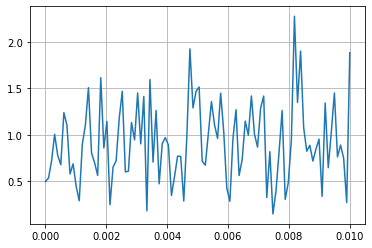

In [190]:
import matplotlib.pyplot as plt

plt.plot(lin, loss_list)
plt.grid()
plt.show()

In [202]:
lin[np.argmin(loss_list)]

0.026326530612244898

2. Подготовьте исходные данные для 5 fold CV.

In [191]:
def k_fold(ds, i, k):
    n = len(ds)
    return torch.cat((ds[:n*(i-1)//k], ds[n*i//k:]), dim=0), ds[n*(i-1)//k: n*i//k]

3. С помощью CV найдите оптимальное значение  𝛼  на какой-нибудь сетке значений.

In [192]:
# Define a utility function to train the model
def fit_k(train_dl, num_epochs, model, loss_fn, opt, alpha):  
    loss_train = []
    loss_val = []
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            # Generate predictions
            pred = model(xb)
            reg = torch.tensor(0.)
            for param in model.parameters():
                reg += param.norm(2)
            loss = loss_fn(pred, yb) + alpha * reg
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
        loss_train.append(loss_fn(model(x_train), y_train))  
        loss_val.append(loss_fn(model(x_test), y_test))
        
    print('Training loss: ', loss_fn(model(x_train), y_train))
    print('Val loss: ', loss_fn(model(x_test), y_test))
    return loss_train, loss_val

In [193]:
k = 5
loss_list_k, loss_train_k, loss_val_k = [], [], []
num_epochs = 100

for i in range(1, k + 1):
    print(i)
    x_train, x_test = k_fold(inputs, i, k)
    y_train, y_test = k_fold(targets.t(), i, k)
    train_ds = TensorDataset(x_train, y_train)
    test_ds = TensorDataset(x_test, y_test)
    
    batch_size = 16
    train_dl = DataLoader(train_ds, batch_size, shuffle=True)
    
    loss_list = []
    lin = np.linspace(0, 0.03, 50)
    for alpha in lin:
        print(alpha)
        model = nn.Linear(4, 1)
        opt = torch.optim.SGD(model.parameters(), lr=1e-5)
        loss_fn = F.mse_loss    
        loss_train, loss_val = fit_k(train_dl, num_epochs, model, loss_fn, opt, 1)
        loss_list.append(loss_fn(model(x_test), y_test))
        
    loss_train_k.append(loss_train) 
    loss_val_k.append(loss_val)
    loss_list_k.append(loss_list)

1
0.0
Training loss:  tensor(1.1812, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.1915, grad_fn=<MseLossBackward>)
0.0006122448979591836
Training loss:  tensor(1.1057, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.2346, grad_fn=<MseLossBackward>)
0.0012244897959183673
Training loss:  tensor(0.2446, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.2307, grad_fn=<MseLossBackward>)
0.001836734693877551
Training loss:  tensor(1.0299, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.1009, grad_fn=<MseLossBackward>)
0.0024489795918367346
Training loss:  tensor(1.2979, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.3963, grad_fn=<MseLossBackward>)
0.003061224489795918
Training loss:  tensor(0.4501, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.4053, grad_fn=<MseLossBackward>)
0.003673469387755102
Training loss:  tensor(0.7562, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.7920, grad_fn=<MseLossBackward>)
0.004285714285714285
Training loss:  tensor(0.6947, grad_fn=<MseLossBackward>)
Val loss:

Training loss:  tensor(0.6244, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.6799, grad_fn=<MseLossBackward>)
0.00857142857142857
Training loss:  tensor(2.0717, grad_fn=<MseLossBackward>)
Val loss:  tensor(2.1170, grad_fn=<MseLossBackward>)
0.009183673469387754
Training loss:  tensor(1.8613, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.7186, grad_fn=<MseLossBackward>)
0.009795918367346938
Training loss:  tensor(0.3328, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.3288, grad_fn=<MseLossBackward>)
0.010408163265306122
Training loss:  tensor(1.4999, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.4616, grad_fn=<MseLossBackward>)
0.011020408163265306
Training loss:  tensor(0.6134, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.5962, grad_fn=<MseLossBackward>)
0.011632653061224489
Training loss:  tensor(1.2489, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.1626, grad_fn=<MseLossBackward>)
0.012244897959183673
Training loss:  tensor(1.0419, grad_fn=<MseLossBackward>)
Val loss:  tensor(1

Training loss:  tensor(1.0207, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.0156, grad_fn=<MseLossBackward>)
0.01653061224489796
Training loss:  tensor(1.4325, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.2202, grad_fn=<MseLossBackward>)
0.01714285714285714
Training loss:  tensor(1.8138, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.7051, grad_fn=<MseLossBackward>)
0.017755102040816324
Training loss:  tensor(0.6485, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.6332, grad_fn=<MseLossBackward>)
0.01836734693877551
Training loss:  tensor(1.3149, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.2818, grad_fn=<MseLossBackward>)
0.018979591836734692
Training loss:  tensor(1.3083, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.3357, grad_fn=<MseLossBackward>)
0.019591836734693877
Training loss:  tensor(1.0646, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.1611, grad_fn=<MseLossBackward>)
0.02020408163265306
Training loss:  tensor(0.4631, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.53

Training loss:  tensor(0.8764, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.7981, grad_fn=<MseLossBackward>)
0.024489795918367346
Training loss:  tensor(0.6300, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.4463, grad_fn=<MseLossBackward>)
0.02510204081632653
Training loss:  tensor(0.2028, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.1867, grad_fn=<MseLossBackward>)
0.025714285714285714
Training loss:  tensor(1.3115, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.0548, grad_fn=<MseLossBackward>)
0.026326530612244898
Training loss:  tensor(1.5475, grad_fn=<MseLossBackward>)
Val loss:  tensor(1.3084, grad_fn=<MseLossBackward>)
0.02693877551020408
Training loss:  tensor(1.2024, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.9926, grad_fn=<MseLossBackward>)
0.027551020408163263
Training loss:  tensor(0.9318, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.7503, grad_fn=<MseLossBackward>)
0.028163265306122447
Training loss:  tensor(1.1074, grad_fn=<MseLossBackward>)
Val loss:  tensor(0.

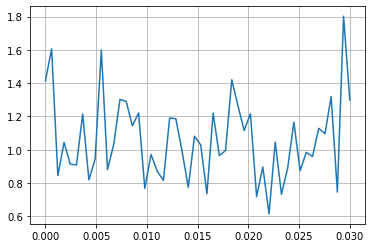

In [194]:
loss_list_k_mean = np.array(loss_list_k).mean(axis=0)
plt.plot(lin, loss_list_k_mean)
plt.grid()
plt.show()

In [195]:
lin[np.argmin(loss_list_k_mean)]

0.022040816326530613

4. Постройте валидационную кривую.
5. Постройте кривую обучения.

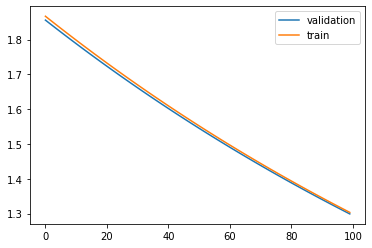

In [197]:
plt.plot(np.arange(100), np.array(loss_val_k).mean(axis=0), label='validation')
plt.plot(np.arange(100), np.array(loss_train_k).mean(axis=0), label='train')

plt.legend()